# Data Vizualization

In [86]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# from datetime import datetime
# from datetime import timedelta
# import numpy as np

In [87]:
df = pd.read_csv('./artifacts/df_rides.csv', index_col=0)
df.reset_index(drop=True, inplace=True)
duration = pd.to_timedelta(df['duration_dt'])
df['duration_min_float'] = duration.dt.total_seconds() / 60
# df['datetime'] = pd.to_datetime(df['datetime'])
# df['duration_dt'] = pd.to_timedelta(df['duration_dt'])

In [88]:
df.describe().T

count       mean        std        min        25%  \
total_earning          3470.0  24.558524  16.991746   5.620000  13.030000   
base_fare              3470.0  23.073118  16.621987   5.620000  11.970000   
customer_fare          3470.0  35.737026  23.556641   8.580000  19.950000   
paid_to_driver         3470.0  25.281115  17.430603   5.620000  13.462500   
paid_to_uber           3470.0   9.585254   8.680952 -42.080000   5.102500   
distance_km            3470.0   6.658297   7.371457   0.020000   2.360000   
fee                    3470.0  27.429581  15.284757 -90.616246  20.360557   
earning_pct            3470.0  70.204783  10.906420  32.239156  61.043617   
earning_base_fare_pct  3470.0  63.425644   9.534290  23.446659  59.931814   
traffic_benchmark      3470.0   3.607731   1.631750   0.789767   2.614625   
ted                    3470.0   1.112550   0.347667   0.403972   0.885709   
bfd                    3470.0   0.993453   0.249791   0.351601   0.821276   
cfd                    3470.0   1.595055   0.455716   0.593958   1.290141   
pud                    3470.0   0.444382   0.296612  -2.205682   0.290959   
tei                    3470.0   5.602553  10.086674   1.161911   3.491867   
bfi                    3470.0   4.896283   8.756327   1.161911   3.283034   
cfi                    3470.0   8.016762  14.525604   1.162530   5.100458   
pui                    3470.0   2.194461   5.201576 -80.833333   1.139288   
tedi                   3470.0   0.876443  10.242608   0.009636   0.148025   
bfdi                   3470.0   0.732493   8.629020   0.009629   0.140451   
cfdi                   3470.0   1.240936  14.432802   0.012690   0.215300   
pudi                   3470.0   0.301500   4.911660 -97.000000   0.044170   
duration_min_float     3470.0  19.488175  15.445384   0.833333   8.804167   

                             50%        75%         max  
total_earning          19.670000  30.427500  203.470000  
base_fare              18.005000  28.537500  203.470000  
customer_fare          29.365000  44.737500  374.870000  
paid_to_driver         20.380000  31.400000  209.470000  
paid_to_uber            8.090000  12.870000  123.400000  
distance_km             4.240000   8.230000  116.490000  
fee                    33.791462  38.763056   41.131956  
earning_pct            65.377545  77.643525  133.773165  
earning_base_fare_pct  61.615294  66.302708  133.773165  
traffic_benchmark       3.379722   4.306939   50.833333  
ted                     1.056841   1.268974    4.247222  
bfd                     0.971925   1.130036    2.572170  
cfd                     1.536867   1.820503    4.436485  
pud                     0.479678   0.627315    1.774434  
tei                     4.666956   6.222674  476.000000  
bfi                     4.330421   5.525008  476.000000  
cfi                     6.856372   9.108022  751.000000  
pui                     2.024844   2.962669  275.000000  
tedi                    0.309462   0.645628  468.196721  
bfdi                    0.282915   0.572904  468.196721  
cfdi                    0.454291   0.959186  738.688525  
pudi                    0.122455   0.275311  270.491803  
duration_min_float     15.025000  24.895833  131.000000

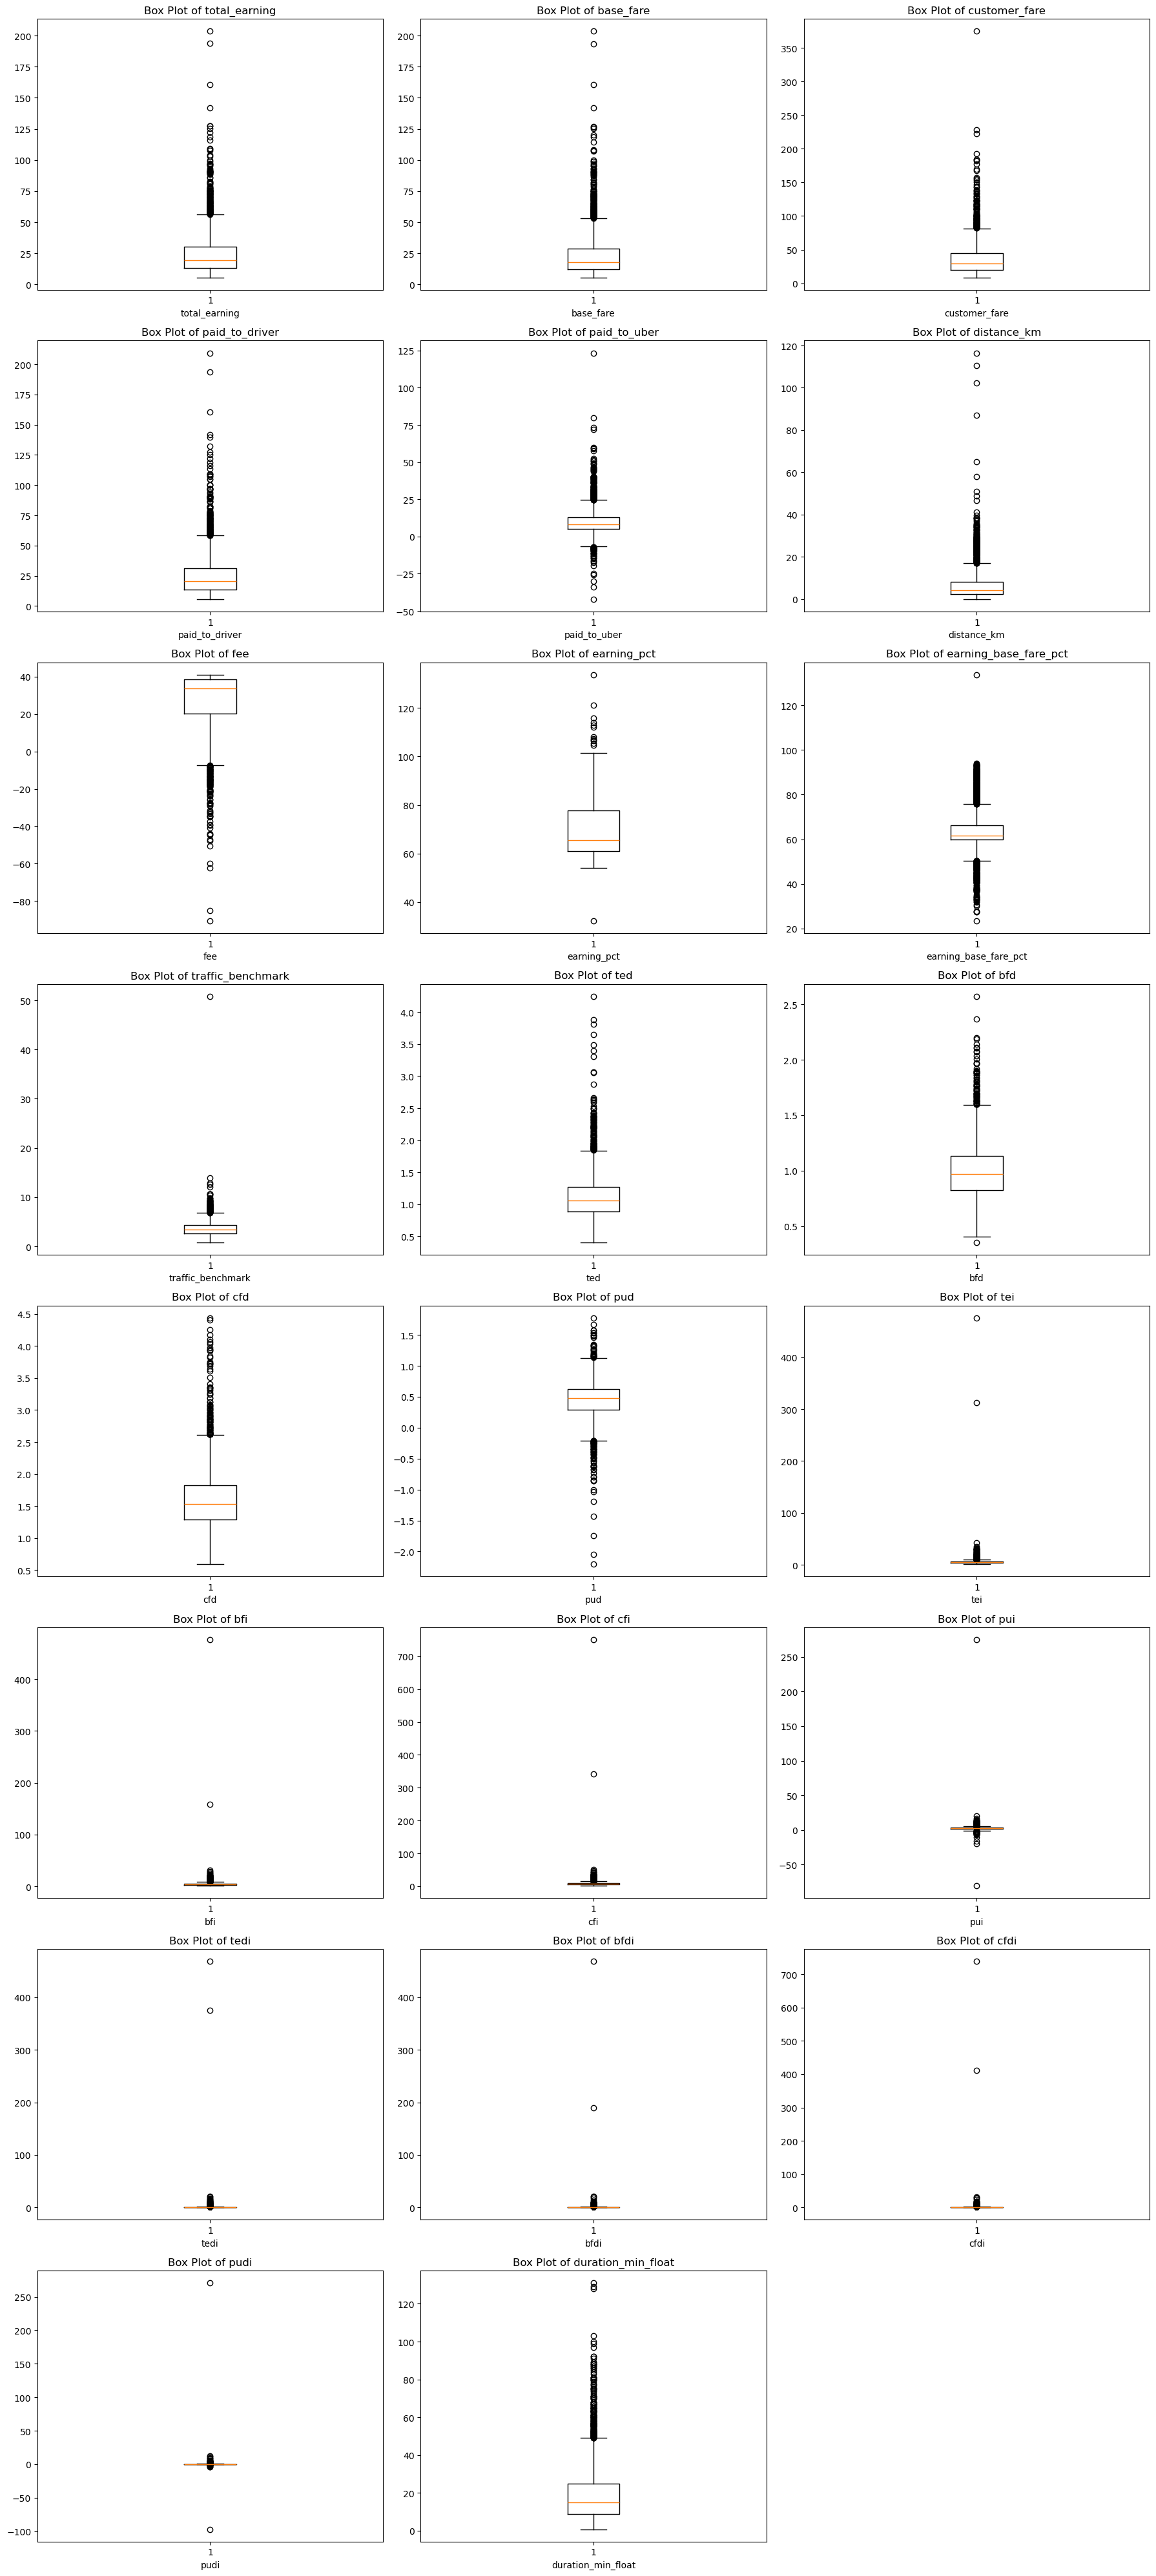

In [89]:
float_columns = df.select_dtypes(include=['float64']).columns
num_cols = len(float_columns)
num_rows = (num_cols // 3) + (num_cols % 3 > 0)  # Calculate number of rows needed

fig, axs = plt.subplots(num_rows, 3, figsize=(18, num_rows * 5))  # Adjust figsize as needed
axs = axs.flatten()  # Flatten the array of axes for easy iteration

for i, col in enumerate(float_columns):
    axs[i].boxplot(df[col])
    axs[i].set_title(f'Box Plot of {col}')
    axs[i].set_xlabel(col)

# Hide any unused subplots
for j in range(i + 1, len(axs)):
    axs[j].axis('off')

plt.tight_layout()
plt.show()

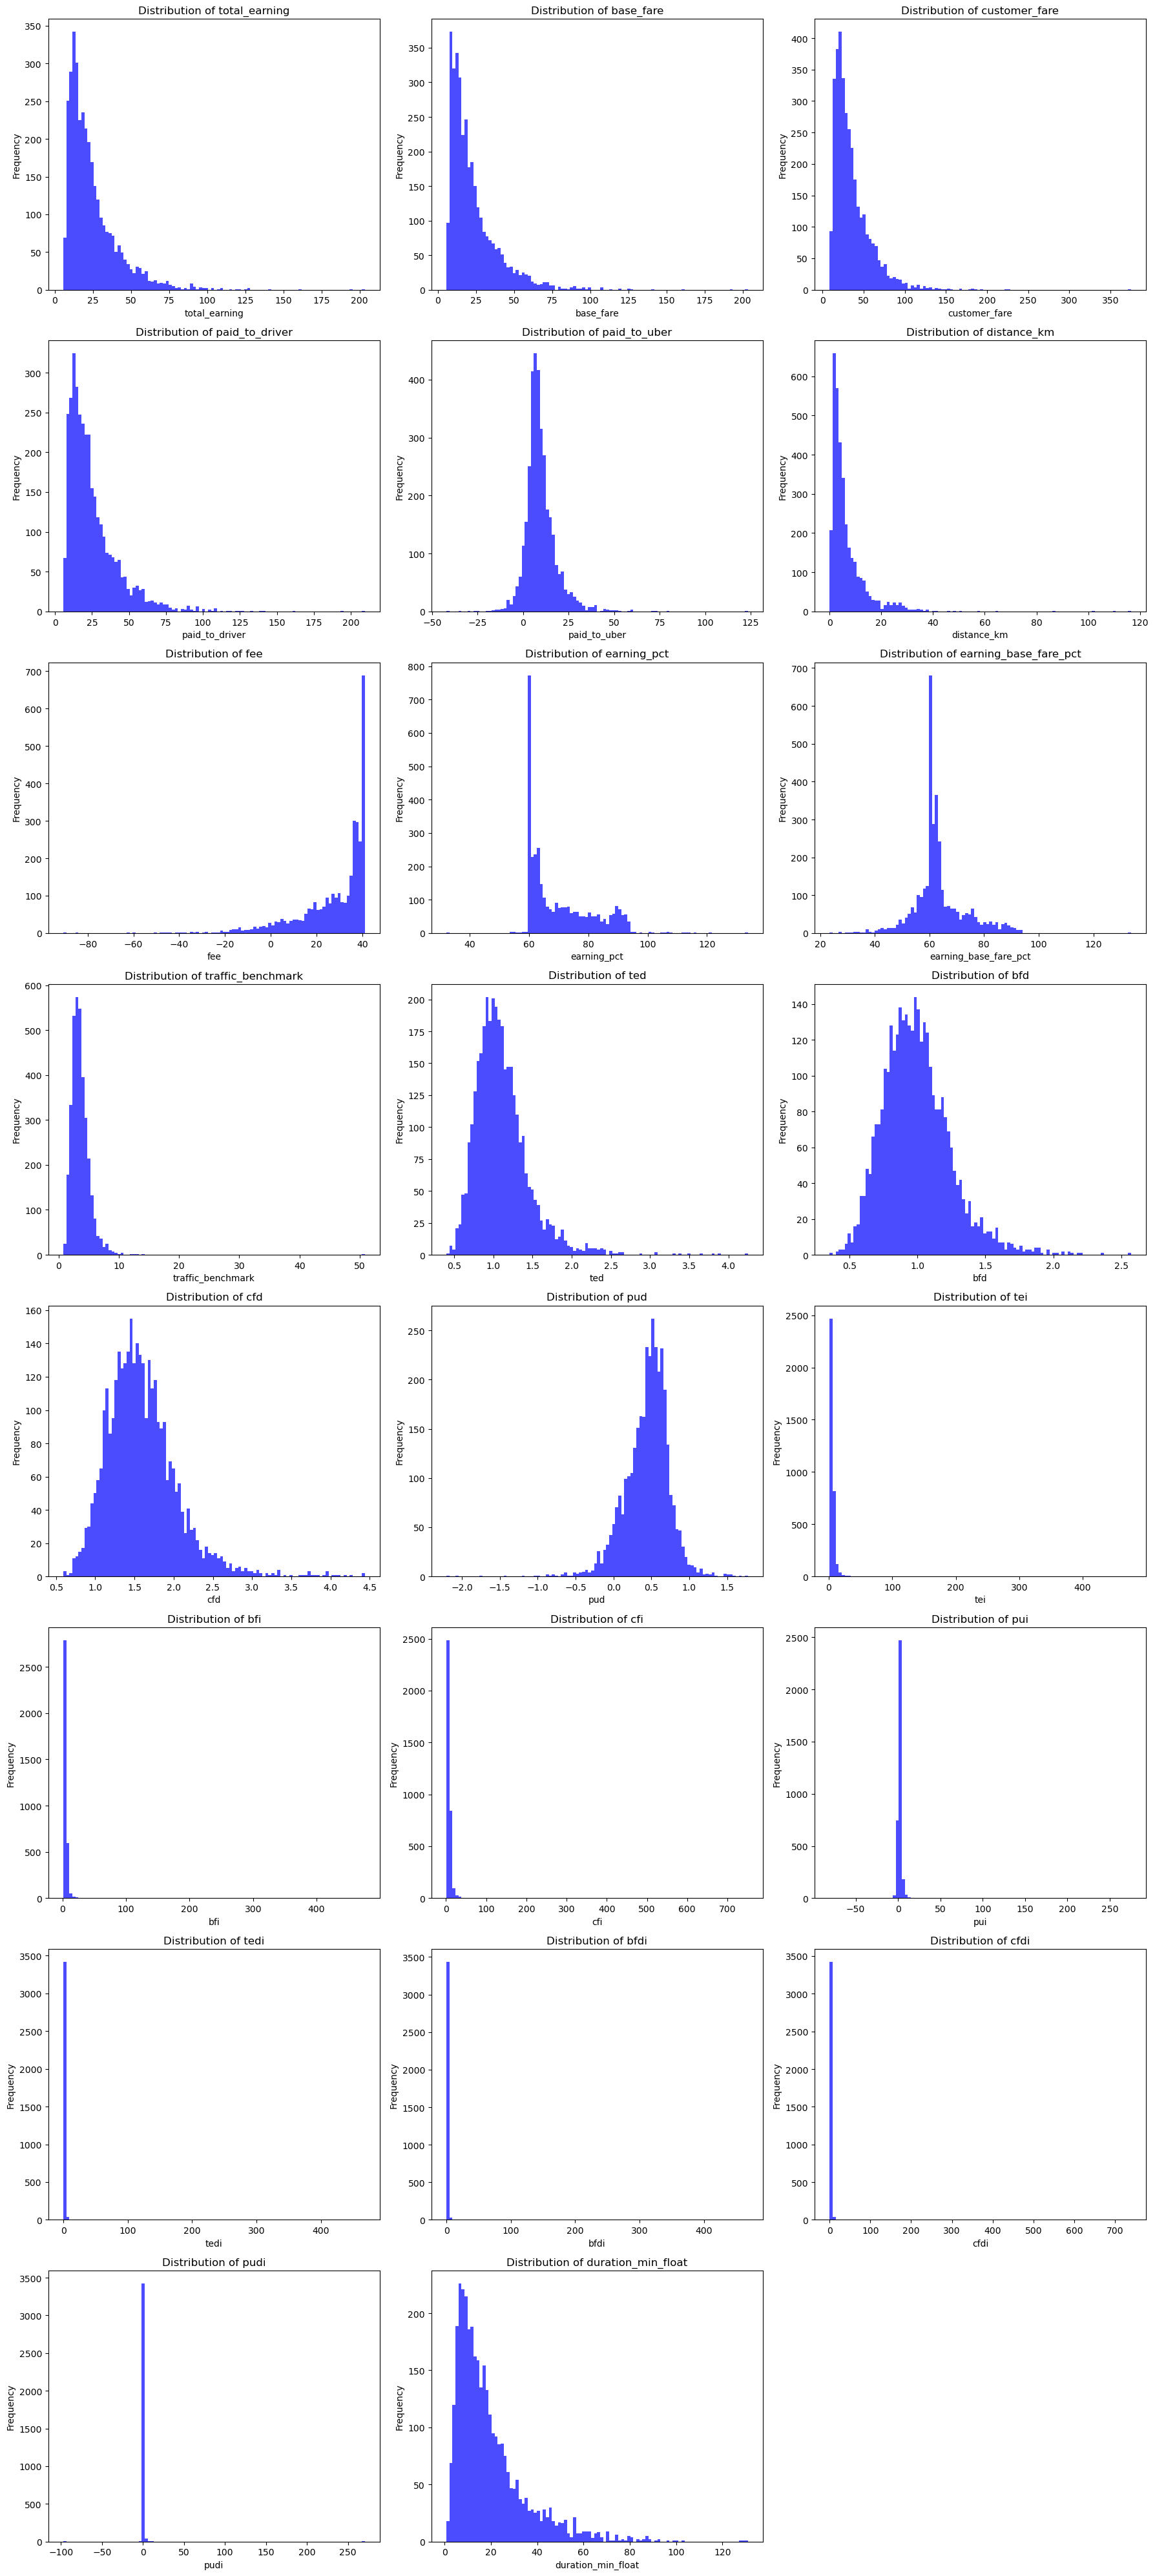

In [90]:
fig, axs = plt.subplots(num_rows, 3, figsize=(18, num_rows * 5))  # Adjust figsize as needed
axs = axs.flatten()  # Flatten the array of axes for easy iteration

for i, col in enumerate(float_columns):
    axs[i].hist(df[col], bins=100, alpha=0.7, color='blue')
    axs[i].set_title(f'Distribution of {col}')
    axs[i].set_xlabel(col)
    axs[i].set_ylabel('Frequency')

# Hide any unused subplots
for j in range(i + 1, len(axs)):
    axs[j].axis('off')

plt.tight_layout()
plt.show()


In [91]:
def adaptive_outlier_removal(df, z_threshold=3, show_impact=True):
    """
    Automatically selects IQR or Z-score based on skewness.
    Returns cleaned DataFrame and method usage report.
    """
    from scipy.stats import skew, zscore
    
    METHOD_REPORT = {}
    clean_df = df.copy()
    clean_col_df = clean_df.copy()
    
    # Business constraints (adjust per domain knowledge)
    BUSINESS_LIMITS = {
        'duration_min_float': (1, 180),       # 1min to 3hrs
        #'distance_km': (0.1, 50),          # 100m to 50km  
        #'total_fare': (2.0, 200),
        #'surge_multiplier': (1.0, 5.0)
    }
    
    # Apply business rules first
    for col in clean_df.select_dtypes(include='number'):
        if col in BUSINESS_LIMITS:
            min_val, max_val = BUSINESS_LIMITS[col]
            mask = (clean_df[col] >= min_val) & (clean_df[col] <= max_val)
            clean_df = clean_df[mask]
    
    # Outlier removal
    for col in clean_df.select_dtypes(include='number'):        
        # Calculate skewness
        col_skew = skew(clean_df[col].dropna())
        METHOD = 'IQR' if abs(col_skew) > 1 else 'Z-score'
        
        # Apply selected method
        if METHOD == 'IQR':
            q1 = clean_df[col].quantile(0.25)
            q3 = clean_df[col].quantile(0.75)
            iqr = q3 - q1
            lower = q1 - 1.5*iqr
            upper = q3 + 1.5*iqr
        else: # Z-score
            z_scores = zscore(clean_df[col].dropna())
            lower = -z_threshold
            upper = z_threshold
            # Align z-scores with original scale
            lower = clean_df[col].mean() + lower*clean_df[col].std()
            upper = clean_df[col].mean() + upper*clean_df[col].std()
        
        # Apply bounds
        mask = (clean_df[col] >= lower) & (clean_df[col] <= upper)
        outliers_removed = len(clean_df) - mask.sum()
        clean_col_df = clean_df[mask]
        clean_skew = skew(clean_col_df[col].dropna())
        
        # Store metrics
        METHOD_REPORT[col] = {
            'method': METHOD,
            'skewness': round(col_skew, 2),
            'outliers_removed': outliers_removed,
            'bounds': (round(lower,2), round(upper,2)),
            'retained': len(clean_col_df),
        }
        
        # Visual comparison
        if show_impact:
            fig, ax = plt.subplots(1,2, figsize=(14,5))
            sns.histplot(df[col], ax=ax[0], color='red', kde=True)
            ax[0].set_title(f'Original {col}\n(Skew: {skew(df[col]):.2f})')
            sns.histplot(clean_col_df[col], ax=ax[1], color='green', kde=True)
            ax[1].set_title(f'Cleaned {col}\n({METHOD} | Skew: {clean_skew:.2f})')
            plt.tight_layout()
            plt.show()
    
    # Print summary
    print(pd.DataFrame(METHOD_REPORT).T)
    return clean_df

# Usage:
viz_df = adaptive_outlier_removal(df, show_impact=False)

                        method skewness outliers_removed           bounds  \
total_earning              IQR      2.5              183  (-13.07, 56.53)   
base_fare                  IQR     2.64              192   (-12.88, 53.4)   
customer_fare              IQR     2.87              149  (-17.24, 81.93)   
paid_to_driver             IQR     2.51              172  (-13.46, 58.33)   
paid_to_uber               IQR     1.92              225   (-6.53, 24.51)   
distance_km                IQR     4.45              256   (-6.45, 17.04)   
fee                        IQR    -1.83              128   (-7.24, 66.37)   
earning_pct            Z-score     0.95               13  (37.49, 102.91)   
earning_base_fare_pct  Z-score     0.67               32   (34.84, 92.02)   
traffic_benchmark          IQR     7.94              109     (0.08, 6.84)   
ted                        IQR     1.78              122     (0.31, 1.84)   
bfd                    Z-score      0.9               38     (0.25, 1.74)   

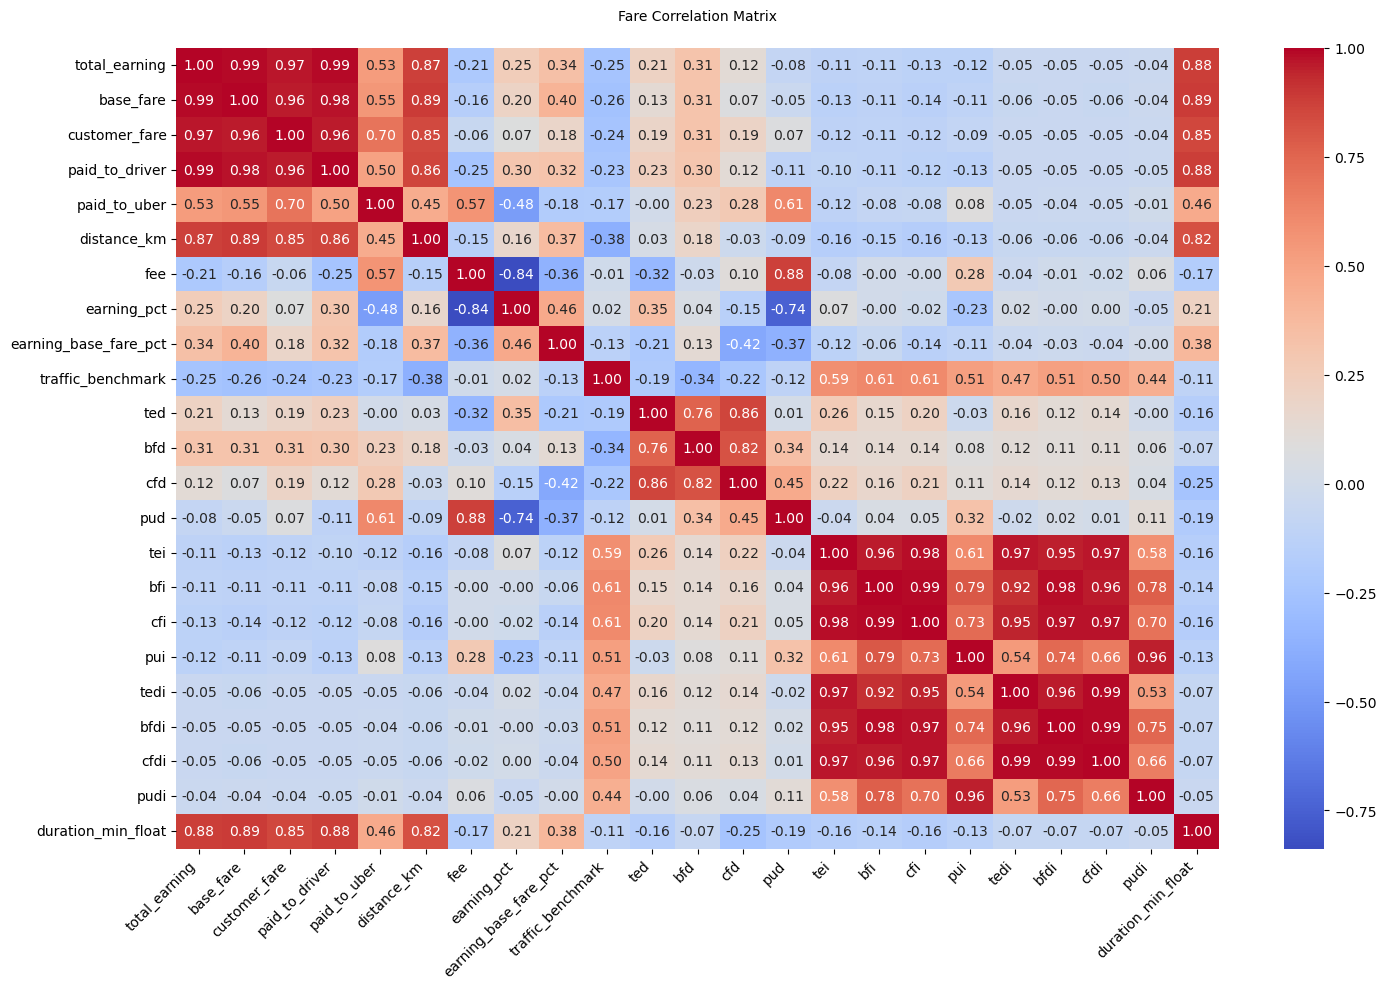

In [92]:
corr_matrix = df.select_dtypes(include='number').corr()

plt.figure(figsize=(15,10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', 
           annot_kws={"size":10}, fmt=".2f",)
           #mask=np.triu(np.ones_like(corr_matrix, dtype=bool)))
plt.title("Fare Correlation Matrix", pad=20, fontsize=10)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

In [93]:
# Outlier removal based on top features
def earnings_aware_outlier_removal(df, 
                                   target_col='tedi', 
                                   number_of_features=4, 
                                   n_estimators=100, 
                                   show_impact=False,
                                   show_report=False):
    """
    Prioritizes outlier removal based on feature impact on 'ted' (total earnings per duration).
    Returns cleaned DataFrame and impact report.
    """
    from sklearn.ensemble import RandomForestRegressor

    # 1. Calculate feature earnings impact on 'ted'
    X = df.select_dtypes(include='number').drop(columns=[target_col], errors='ignore')
    y = df[target_col]

    model = RandomForestRegressor(n_estimators=n_estimators) # Increased estimators for robustness
    model.fit(X, y)
    feature_impact = pd.Series(model.feature_importances_, index=X.columns)
    top_features = feature_impact.nlargest(number_of_features).index.tolist() # Top 5 features as requested
    top_features.insert(0, target_col)
    
    # 2. Adaptive outlier removal
    def adaptive_outlier_removal(df, 
                                 z_threshold=3, 
                                 show_impact=show_impact, 
                                 top_features=top_features,
                                 show_report=show_report):
        """
        Automatically selects IQR or Z-score based on skewness.
        Returns cleaned DataFrame and method usage report.
        """
        from scipy.stats import skew, zscore
        
        METHOD_REPORT = {}
        clean_df = df.copy()
        
        # Business constraints (adjust per domain knowledge)
        BUSINESS_LIMITS = {
            'duration_min_float': (1, 180),       # 1min to 3hrs
            #'distance_km': (0.1, 50),          # 100m to 50km  
            #'total_fare': (2.0, 200),
            #'surge_multiplier': (1.0, 5.0)
        }
        
        # Apply business rules first
        for col in clean_df.select_dtypes(include='number'):
            if col in BUSINESS_LIMITS:
                min_val, max_val = BUSINESS_LIMITS[col]
                mask = (clean_df[col] >= min_val) & (clean_df[col] <= max_val)
                clean_df = clean_df[mask]
        
        # Outlier removal
        for col in clean_df[top_features].columns:        
            # Calculate skewness
            col_skew = skew(clean_df[col].dropna())
            METHOD = 'IQR' if abs(col_skew) > 1 else 'Z-score'
            
            # Apply selected method
            if METHOD == 'IQR':
                q1 = clean_df[col].quantile(0.25)
                q3 = clean_df[col].quantile(0.75)
                iqr = q3 - q1
                lower = q1 - 1.5*iqr
                upper = q3 + 1.5*iqr
            else: # Z-score
                z_scores = zscore(clean_df[col].dropna())
                lower = -z_threshold
                upper = z_threshold
                # Align z-scores with original scale
                lower = clean_df[col].mean() + lower*clean_df[col].std()
                upper = clean_df[col].mean() + upper*clean_df[col].std()
            
            # Apply bounds
            mask = (clean_df[col] >= lower) & (clean_df[col] <= upper)
            outliers_removed = len(clean_df) - mask.sum()
            clean_df = clean_df[mask]
            clean_skew = skew(clean_df[col].dropna())
            
            # Store metrics
            METHOD_REPORT[col] = {
                'method': METHOD,
                'skewness': round(col_skew, 2),
                'outliers_removed': outliers_removed,
                'bounds': (round(lower,2), round(upper,2)),
                'retained': len(clean_df),
            }
            
            # Visual comparison
            if show_impact:
                fig, ax = plt.subplots(1,2, figsize=(14,5))
                sns.histplot(df[col], ax=ax[0], color='red', kde=True)
                ax[0].set_title(f'Original {col}\n(Skew: {skew(df[col]):.2f})')
                sns.histplot(clean_df[col], ax=ax[1], color='green', kde=True)
                ax[1].set_title(f'Cleaned {col}\n({METHOD} | Skew: {clean_skew:.2f})')
                plt.tight_layout()
                plt.show()
        
        # Print summary
        if show_report:
            print(pd.DataFrame(METHOD_REPORT).T)
        return clean_df
    
    clean_df = adaptive_outlier_removal(df)
    return clean_df

clean_df = earnings_aware_outlier_removal(df)

# Business Impact Analysis:
print(f"Original records: {len(df):,}")
print(f"Cleaned records: {len(clean_df):,}")
print(f"Data retention: {len(clean_df)/len(df):.1%}")

Original records: 3,470
Cleaned records: 2,917
Data retention: 84.1%


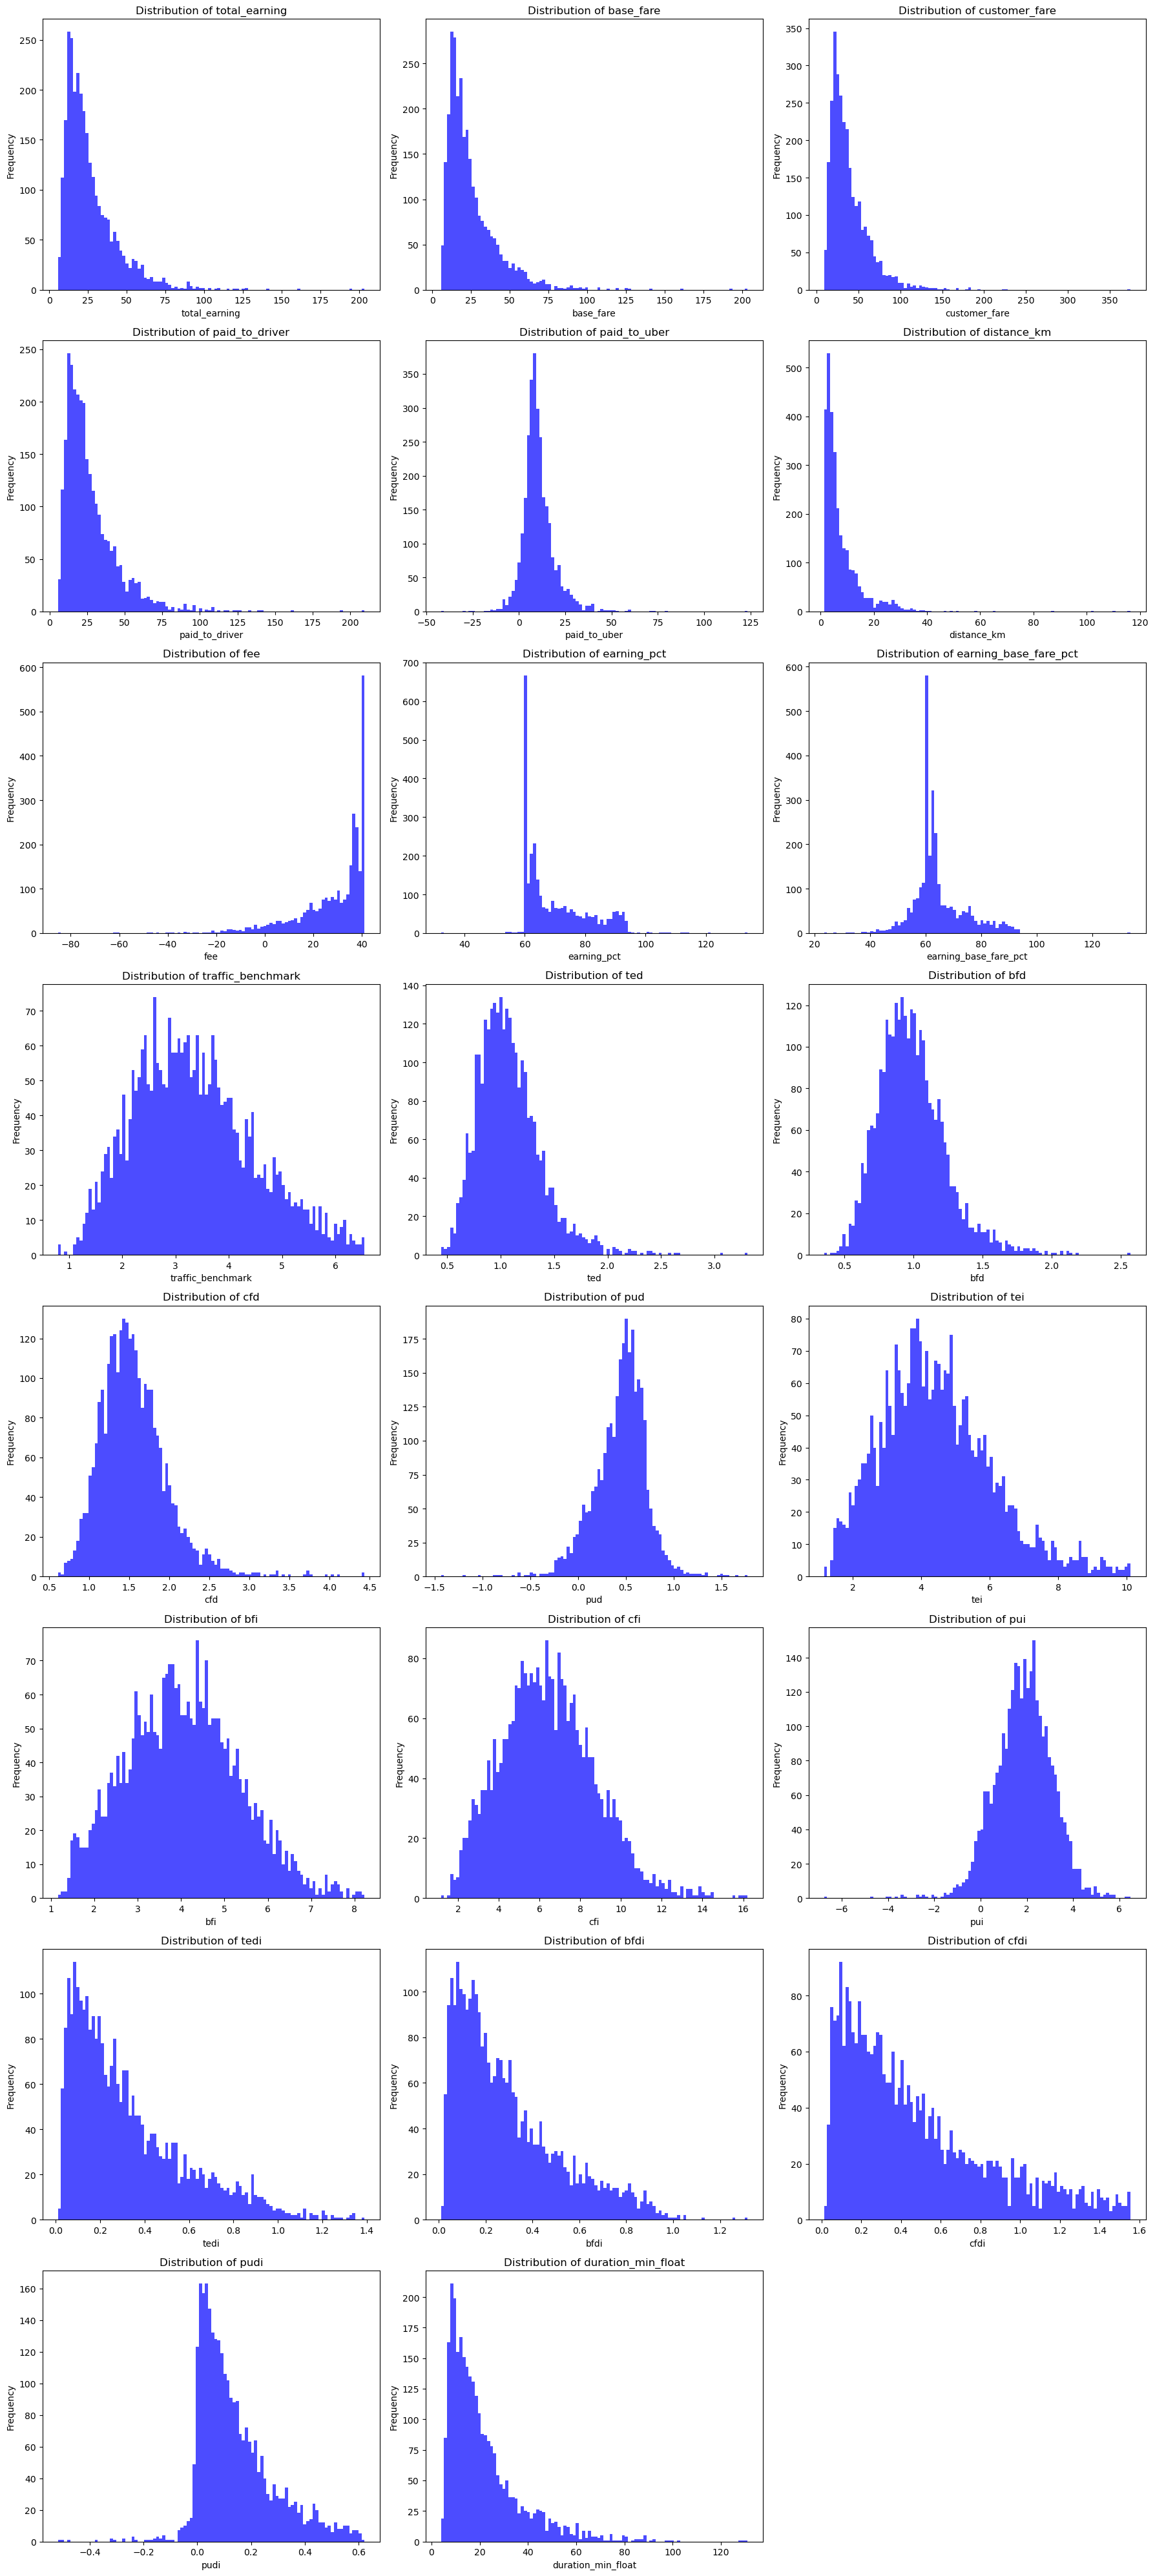

In [94]:
fig, axs = plt.subplots(num_rows, 3, figsize=(18, num_rows * 5))  # Adjust figsize as needed
axs = axs.flatten()  # Flatten the array of axes for easy iteration

for i, col in enumerate(float_columns):
    axs[i].hist(clean_df[col], bins=100, alpha=0.7, color='blue')
    axs[i].set_title(f'Distribution of {col}')
    axs[i].set_xlabel(col)
    axs[i].set_ylabel('Frequency')

# Hide any unused subplots
for j in range(i + 1, len(axs)):
    axs[j].axis('off')

plt.tight_layout()

In [95]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2917 entries, 0 to 3469
Data columns (total 34 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   type                   2917 non-null   object 
 1   date                   2917 non-null   object 
 2   time                   2917 non-null   object 
 3   duration               2917 non-null   object 
 4   distance               2917 non-null   object 
 5   origin                 2917 non-null   object 
 6   destination            2917 non-null   object 
 7   total_earning          2917 non-null   float64
 8   base_fare              2917 non-null   float64
 9   customer_fare          2917 non-null   float64
 10  paid_to_driver         2917 non-null   float64
 11  paid_to_uber           2917 non-null   float64
 12  datetime               2917 non-null   object 
 13  duration_dt            2917 non-null   object 
 14  distance_km            2917 non-null   float64
 15  origin_la

In [99]:
clean_df['type'].unique()

array(['UberX', 'Comfort', 'Prioridade', 'Flash', 'Comfort Planet',
       'Black', 'Black Bag', 'VIP', 'Business Comfort', 'Business Black'],
      dtype=object)

In [100]:
clean_df['datetime'] = pd.to_datetime(clean_df['datetime'])

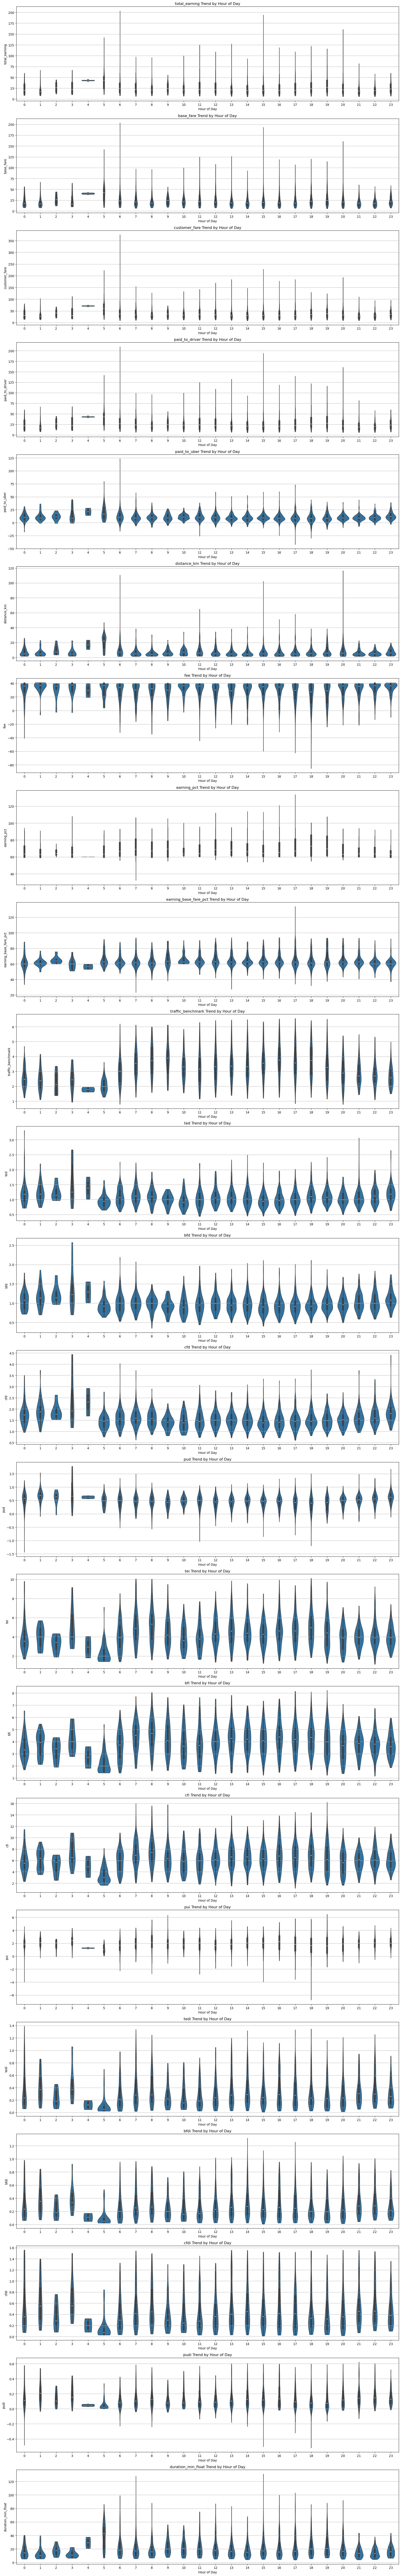

In [101]:
# Extract hour of the day
clean_df['hour_of_day'] = clean_df['datetime'].dt.hour

float_columns = clean_df.select_dtypes(include=['float64']).columns

num_cols = len(float_columns)
num_rows = (num_cols // 1) + (num_cols % 1 > 0)

fig, axs = plt.subplots(num_rows, ncols=1, figsize=(18, num_rows * 5))
axs = axs.flatten()

for i, col in enumerate(float_columns):
    sns.violinplot(x='hour_of_day', y=col, data=clean_df, ax=axs[i], cut=0) # Violin plot with hour on x-axis 
    axs[i].set_title(f'{col} Trend by Hour of Day')
    axs[i].set_xlabel('Hour of Day')
    axs[i].set_ylabel(col)
    axs[i].set_xticks(range(24)) # Ensure all hours are shown
    axs[i].yaxis.grid(True)

for j in range(i + 1, len(axs)):
    axs[j].axis('off')

plt.tight_layout()
plt.show()

In [102]:
clean_df.head().T

0  \
type                                                               UberX   
date                                                          2023-11-11   
time                                                            17:28:00   
duration                                                   11 min 32 sec   
distance                                                         4.15 km   
origin                 Rua Antônio das Chagas, Santo Amaro - São Paul...   
destination            R. Geórgia, Brooklin - São Paulo - SP, 04559-0...   
total_earning                                                      15.01   
base_fare                                                          11.01   
customer_fare                                                      19.97   
paid_to_driver                                                     15.01   
paid_to_uber                                                        4.96   
datetime                                             2023-11-11 17:28:00   
duration_dt                                              0 days 00:11:32   
distance_km                                                         4.15   
origin_lat_lng                                [-23.6310457, -46.7009751]   
destination_lat_lng                           [-23.6108945, -46.6774821]   
fee                                                            24.837256   
earning_pct                                                    75.162744   
earning_base_fare_pct                                          55.132699   
traffic_benchmark                                               2.779116   
ted                                                             0.966309   
bfd                                                             0.708798   
cfd                                                             1.285622   
pud                                                             0.319313   
tei                                                             3.616867   
bfi                                                             2.653012   
cfi                                                             4.812048   
pui                                                             1.195181   
tedi                                                            0.313601   
bfdi                                                             0.23003   
cfdi                                                             0.41723   
pudi                                                            0.103628   
duration_min_float                                             11.533333   
hour_of_day                                                           17   

                                                                       1  \
type                                                               UberX   
date                                                          2023-11-11   
time                                                            16:37:00   
duration                                                   27 min 43 sec   
distance                                                        13.42 km   
origin                 Rua Helena, Itaim Bibi - São Paulo - SP, 04552...   
destination            Rua Quipa, Campo Limpo - São Paulo - SP, 05756...   
total_earning                                                      27.09   
base_fare                                                          27.09   
customer_fare                                                      34.95   
paid_to_driver                                                     27.09   
paid_to_uber                                                        7.86   
datetime                                             2023-11-11 16:37:00   
duration_dt                                              0 days 00:27:43   
distance_km                                                        13.42   
origin_lat_lng                                 [-23.5930876, -46.685821]   
destination_lat_lng                       

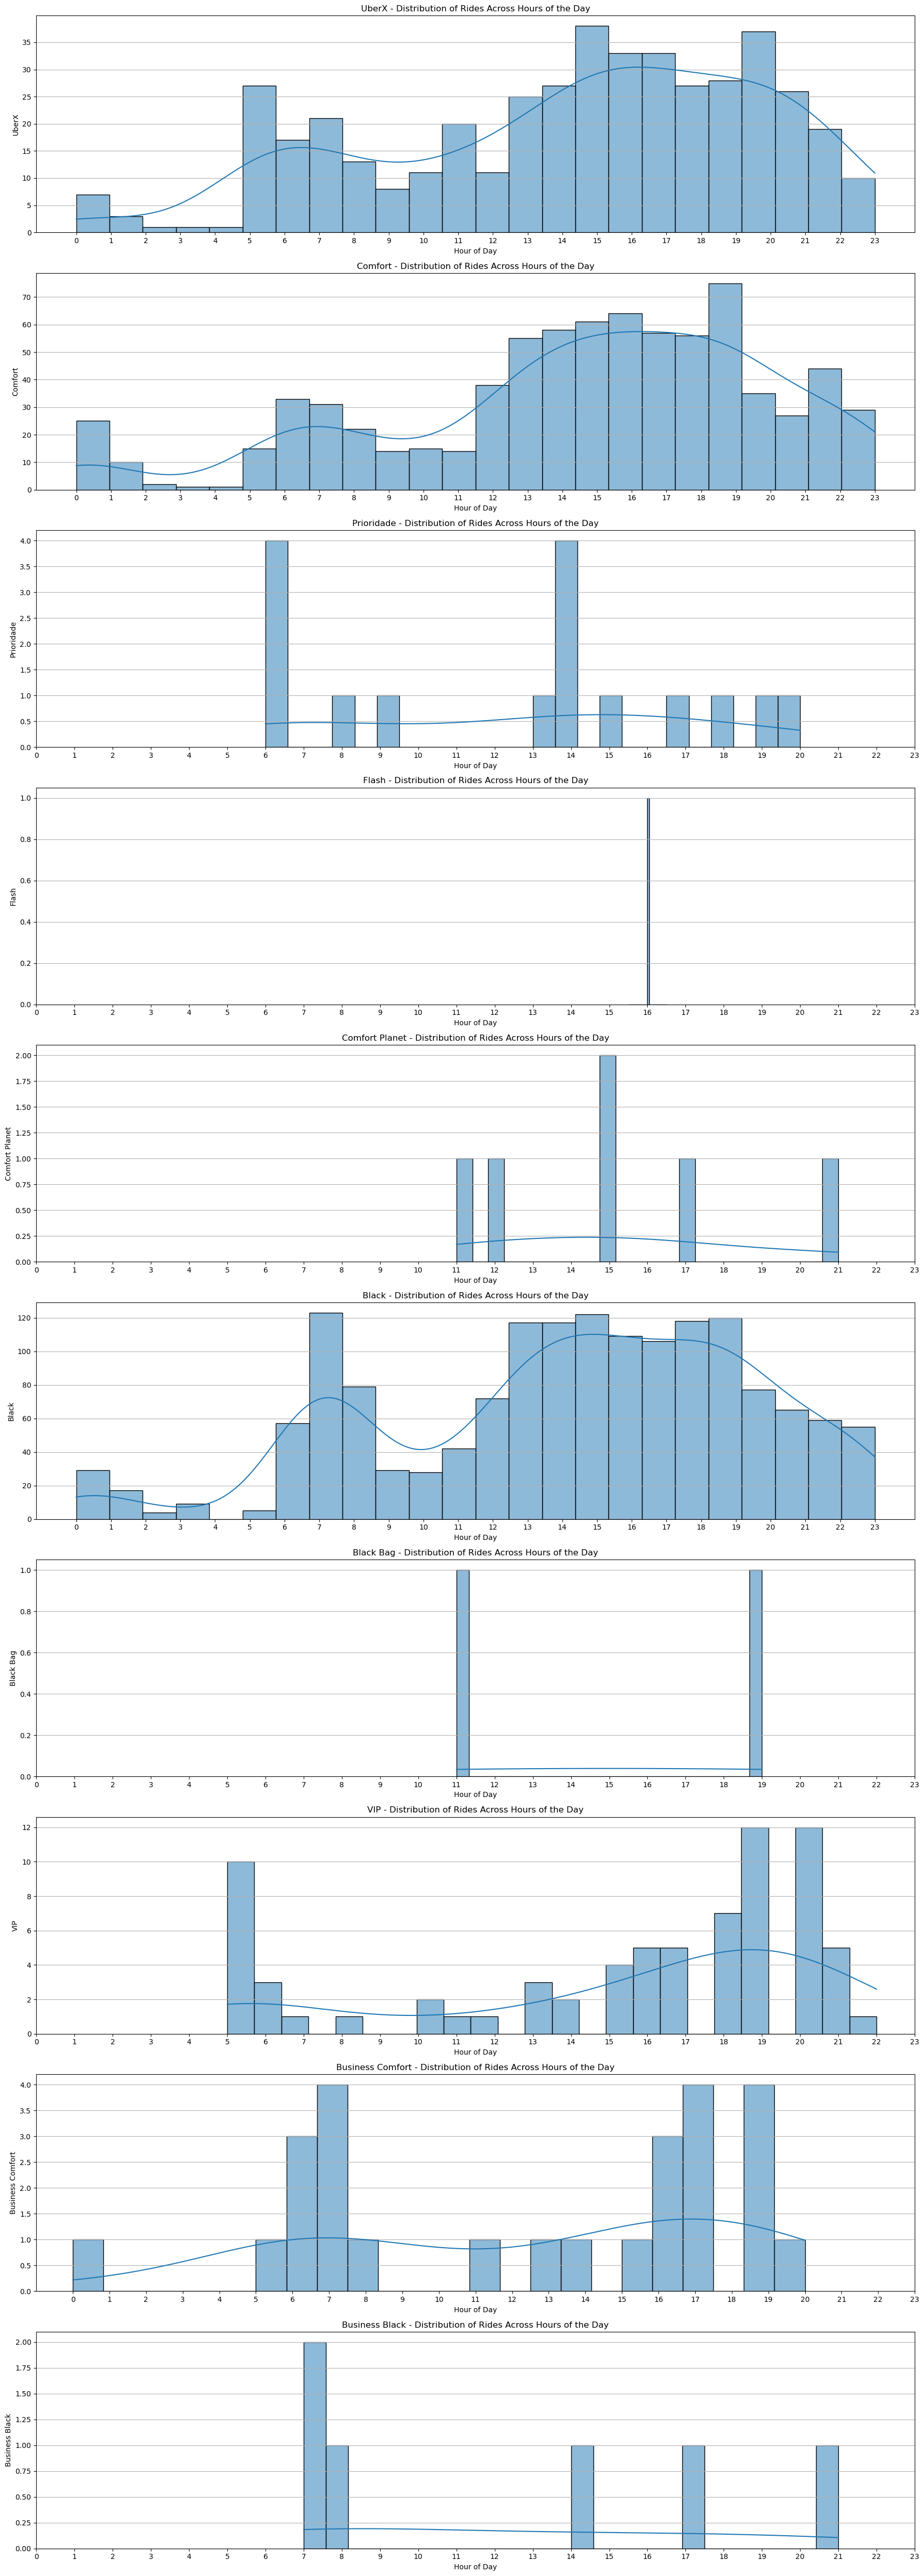

In [104]:
types = clean_df['type'].unique()

num_cols = len(types)
num_rows = num_cols #(num_cols // 1) + (num_cols % 1 > 0)

fig, axs = plt.subplots(num_rows, ncols=1, figsize=(18, num_rows * 5))
axs = axs.flatten()

for i, type_ in enumerate(types):
    data = clean_df[clean_df['type'] == type_]
    sns.histplot(x='hour_of_day', data=data, bins=24, kde=True, 
                 legend=True, stat='count', fill=True, ax=axs[i])
    axs[i].set_title(f'{type_} - Distribution of Rides Across Hours of the Day')
    axs[i].set_xlabel('Hour of Day')
    axs[i].set_ylabel(type_)
    axs[i].set_xticks(range(24)) # Ensure all hours are shown
    axs[i].yaxis.grid(True)

for j in range(i + 1, len(axs)):
    axs[j].axis('off')

plt.tight_layout()
plt.show()

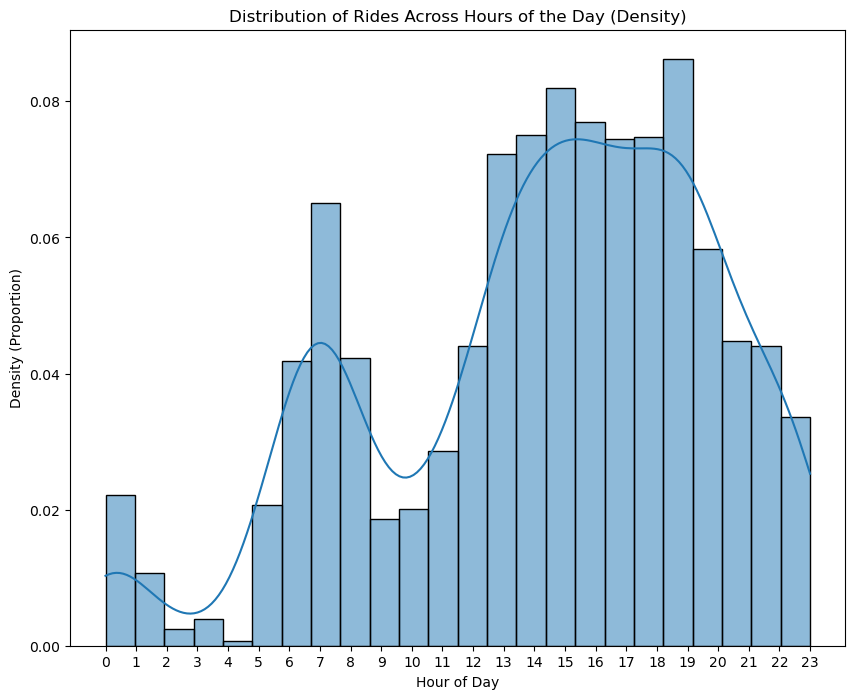

In [105]:
# Extract hour of the day
clean_df['hour_of_day'] = clean_df['datetime'].dt.hour

figure = plt.figure(figsize=(10, 8))
sns.histplot(x='hour_of_day', data=clean_df, bins=24, kde=True, legend=False, stat='density', fill=True)
plt.title('Distribution of Rides Across Hours of the Day (Density)')
plt.xlabel('Hour of Day')
plt.ylabel('Density (Proportion)')

plt.xticks(range(24)) # Ensure all hours are shown
plt.show()

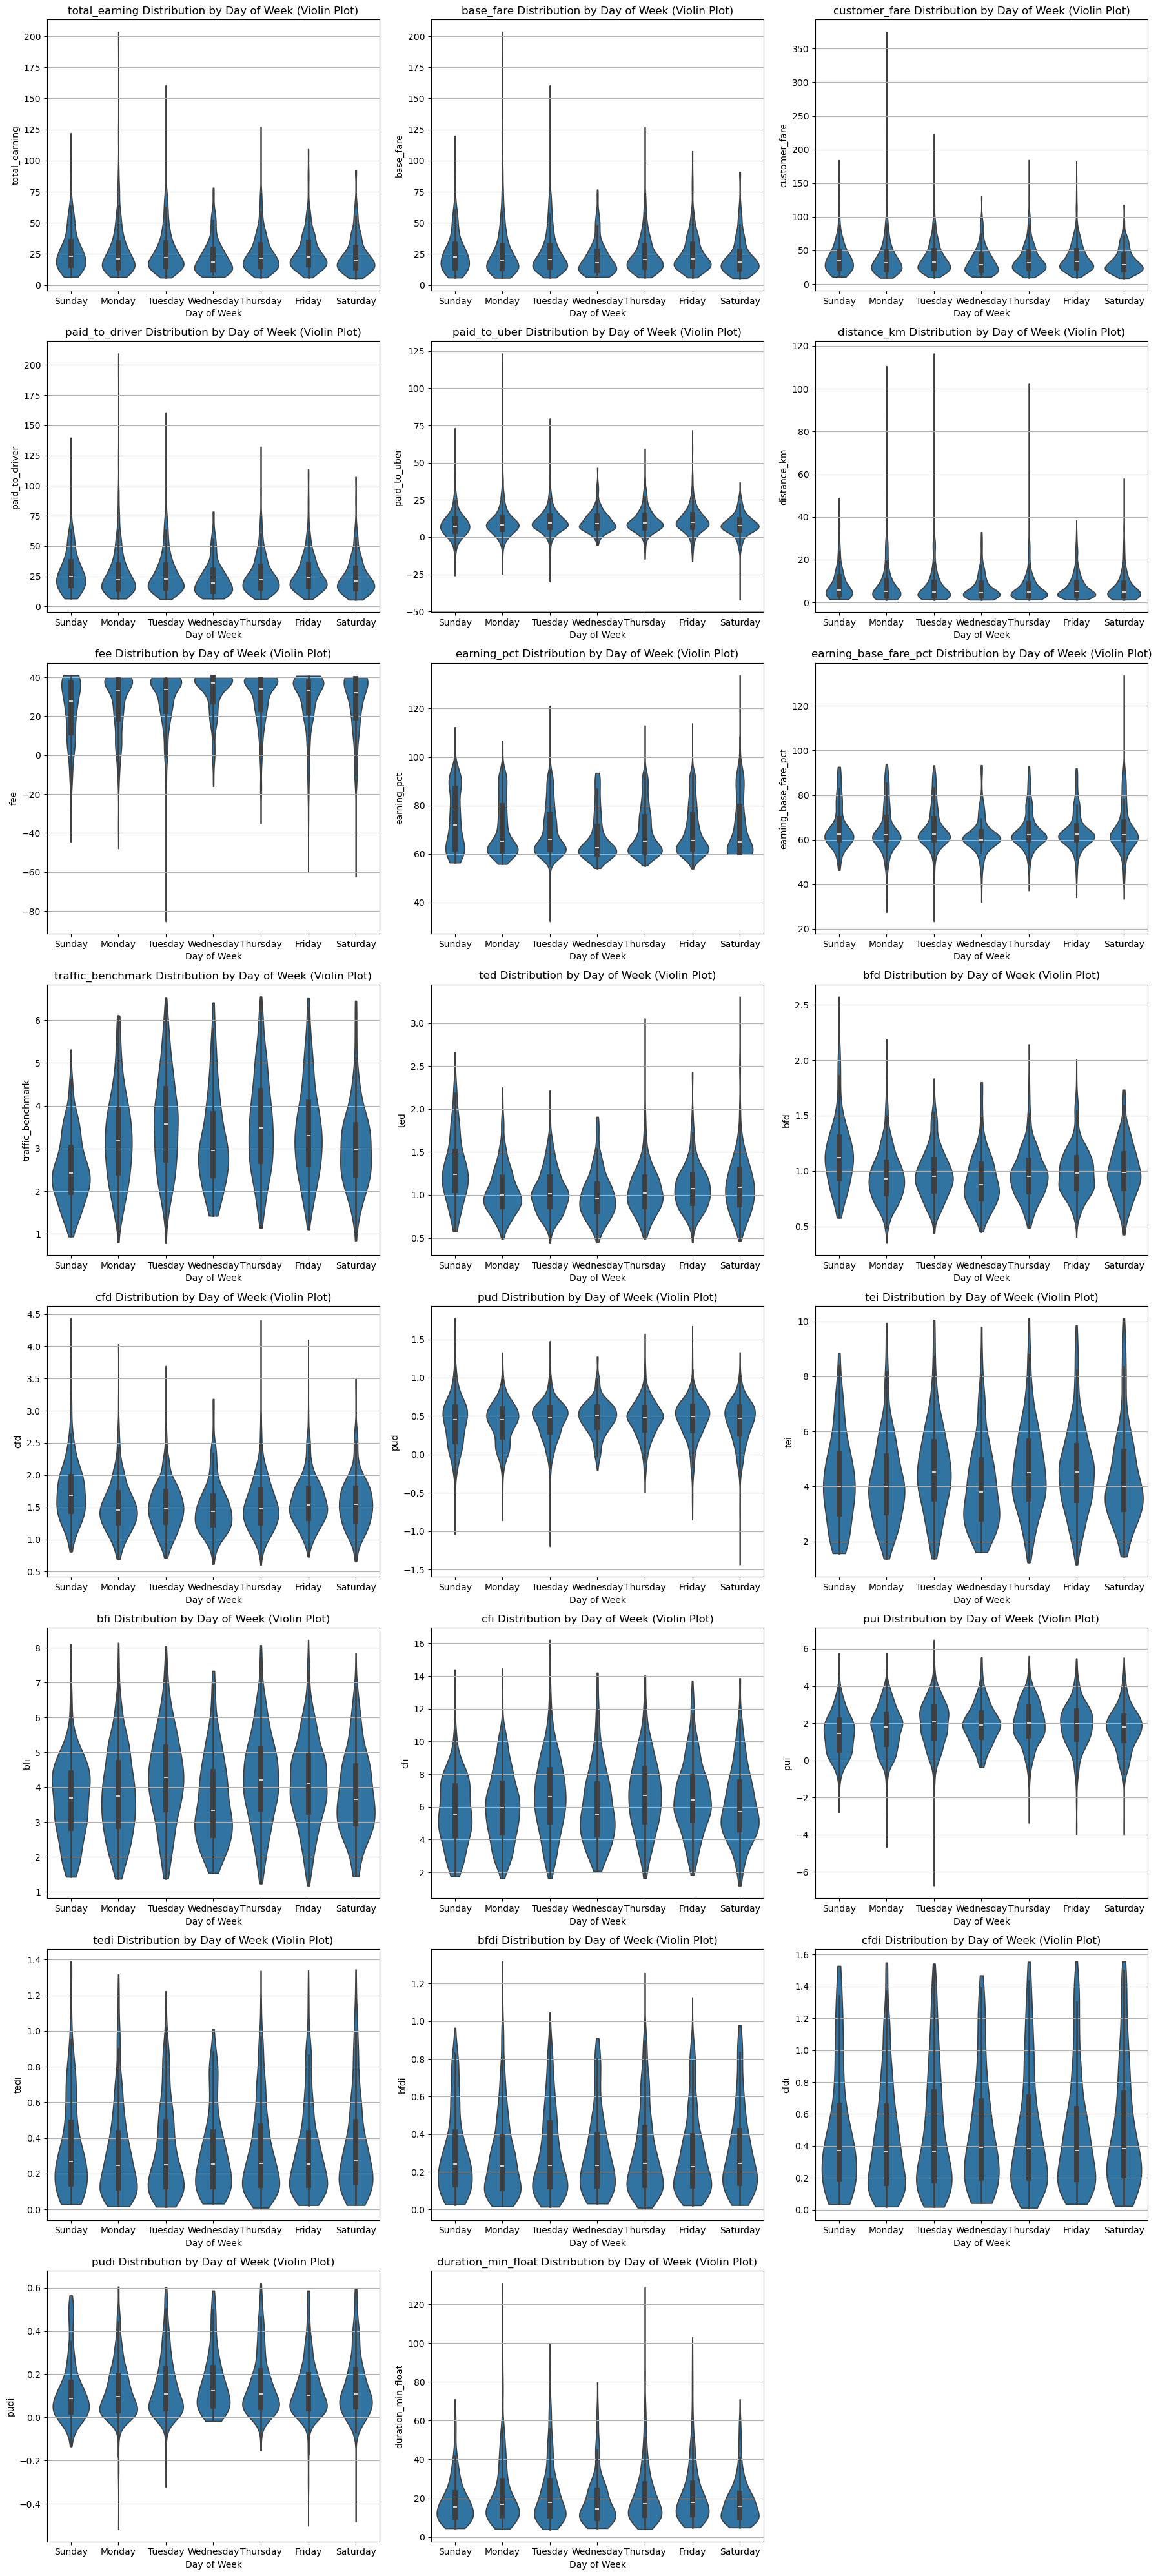

In [106]:
clean_df['datetime_dt'] = pd.to_datetime(clean_df['datetime'])
clean_df['day_of_week'] = clean_df['datetime_dt'].dt.day_name() # Or use .dt.weekday for numerical day of week

float_columns = clean_df.select_dtypes(include=['float64']).columns

num_cols = len(float_columns)
num_rows = (num_cols // 3) + (num_cols % 3 > 0)

fig, axs = plt.subplots(num_rows, 3, figsize=(18, num_rows * 5))
axs = axs.flatten()

day_order = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 
             'Friday', 'Saturday'] # For ordered days

for i, col in enumerate(float_columns):
    sns.violinplot(x='day_of_week', y=col, data=clean_df, ax=axs[i], cut=0, order=day_order) # Violin plot by day of week, ordered days
    axs[i].set_title(f'{col} Distribution by Day of Week (Violin Plot)')
    axs[i].set_xlabel('Day of Week')
    axs[i].set_ylabel(col)
    axs[i].yaxis.grid(True)

for j in range(i + 1, len(axs)):
    axs[j].axis('off')

plt.tight_layout()
plt.show()

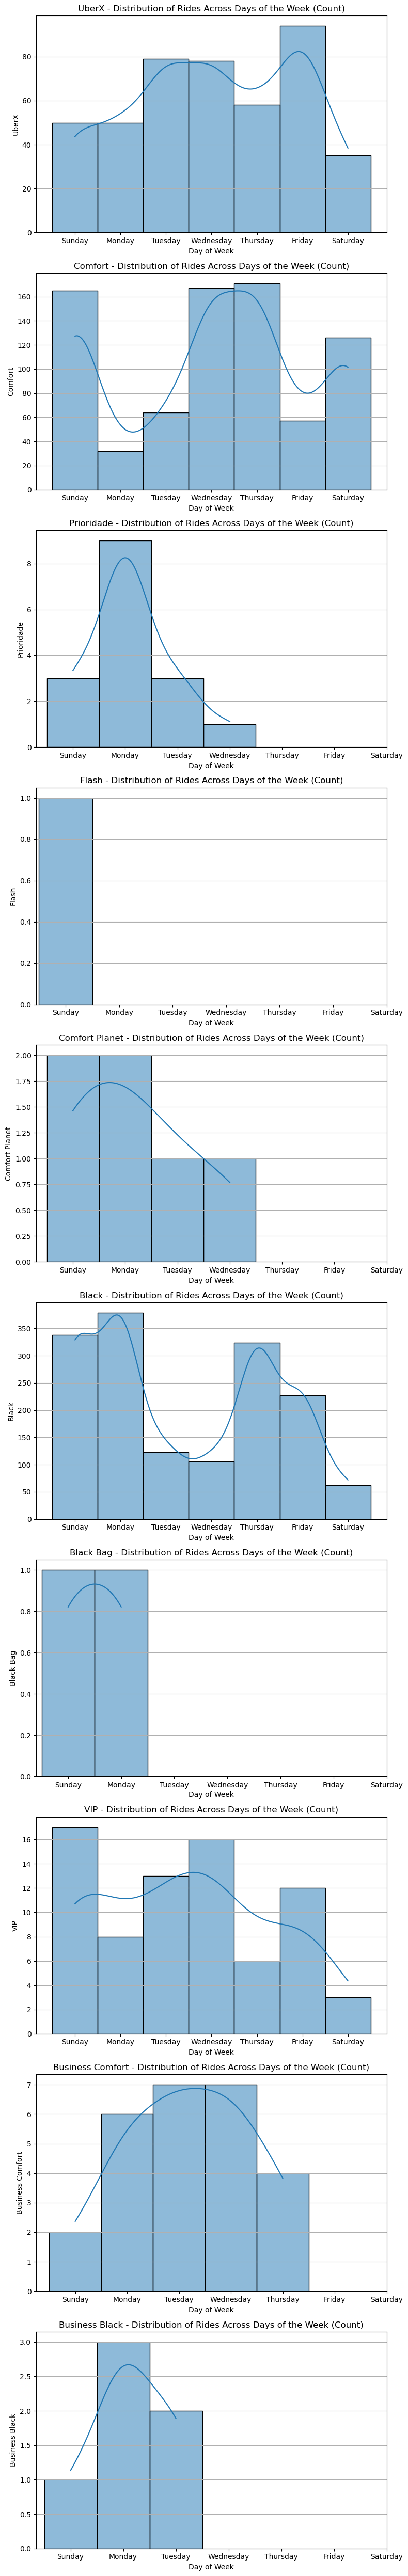

In [108]:
clean_df['datetime_dt'] = pd.to_datetime(clean_df['datetime'])
clean_df['day_of_week'] = clean_df['datetime_dt'].dt.day_name() # Or use .dt.weekday for numerical day of week
day_order = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 
             'Friday', 'Saturday'] # For ordered days

types = clean_df['type'].unique()

num_cols = len(types)
num_rows = num_cols #(num_cols // 1) + (num_cols % 1 > 0)

fig, axs = plt.subplots(num_rows, ncols=1, figsize=(8, num_rows * 5))
axs = axs.flatten()

for i, type_ in enumerate(types):
    data = clean_df[clean_df['type'] == type_]
    sns.histplot(x='day_of_week', data=data, bins=7, kde=True, 
                 legend=True, stat='count', fill=True, ax=axs[i])
    axs[i].set_title(f'{type_} - Distribution of Rides Across Days of the Week (Count)')
    axs[i].set_xlabel('Day of Week')
    axs[i].set_ylabel(type_)
    axs[i].set_xticks(range(7), labels=day_order) # Ensure all hours are shown
    axs[i].yaxis.grid(True)

for j in range(i + 1, len(axs)):
    axs[j].axis('off')

plt.tight_layout()
plt.show()

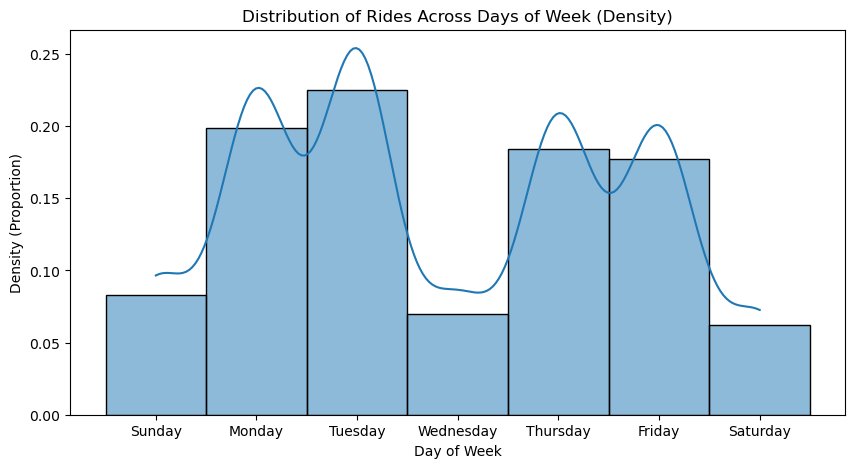

In [109]:
clean_df['datetime_dt'] = pd.to_datetime(clean_df['datetime'])
clean_df['day_of_week'] = clean_df['datetime_dt'].dt.day_name() # Or use .dt.weekday for numerical day of week
day_order = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 
             'Friday', 'Saturday'] # For ordered days

figure = plt.figure(figsize=(10, 5))
sns.histplot(x='day_of_week', data=clean_df, bins=7, kde=True, legend=False, 
             stat='density')
plt.title('Distribution of Rides Across Days of Week (Density)')
plt.xlabel('Day of Week')
plt.ylabel('Density (Proportion)')

plt.xticks(range(7), day_order) # Ensure all days are shown in the correct order
plt.show()

In [110]:
import folium
from folium.plugins import HeatMap
from sklearn.cluster import DBSCAN
import numpy as np
import geopandas as gpd

# Load the GeoDataFrame
geodf = gpd.read_parquet('./data/br_geo_gdf.parquet')

# Load data for geodf
scdf = pd.read_csv('./data/br_data.csv')
scdf =scdf[scdf['Nome_da_UF '] == 'São Paulo']

# Merge the GeoDataFrame with the DataFrame
geodf['Cod_setor'] = geodf['Cod_setor'].astype('str')
scdf['Cod_setor'] = scdf['Cod_setor'].astype('str')
gdf = pd.merge(scdf, geodf, how='left', on='Cod_setor')

# Filter data for family earnings and density
filtered_gdf = gdf[(gdf['renda_dom'] >= 4.418) & (gdf['densidade'] >= 150)]
filtered_gdf = gpd.GeoDataFrame(filtered_gdf, geometry='geometry')

borders_style = {
        'color': 'green',
        'weight': 0,
        'fillColor': 'green',
        'fillOpacity': 0.2,
    }

In [ ]:
# 1. Parse 'origin_lat_lng' into separate lat and lng columns
clean_df['origin_lat'] = round(clean_df['origin_lat_lng'].str.replace('[', '').\
    str.replace(']', '').str.split(',', expand=True)[0].astype(float),6)
clean_df['origin_lng'] = round(clean_df['origin_lat_lng'].str.replace('[', '').\
    str.replace(']', '').str.split(',', expand=True)[1].astype(float),6)

# 2. Apply DBSCAN clustering
radius = 100  
radius_in_degrees = radius / 111300  # 1 degree is approximately 111300 meters
coords = clean_df[['origin_lat', 'origin_lng']].values
db = DBSCAN(eps=radius_in_degrees, min_samples=3).fit(coords)  # Adjust eps and min_samples as needed
clean_df['cluster'] = db.labels_

# 3. Aggregate 'ted' by cluster
clustered_location = clean_df.groupby('cluster').agg({
    'origin_lat': 'mean',
    'origin_lng': 'mean',
    'ted': 'mean',
    'type' : 'count'
}).reset_index()

# 4. Create a Folium map centered around the average latitude and longitude
map_center_lat = clustered_location['origin_lat'].mean()
map_center_lng = clustered_location['origin_lng'].mean()

ride_map = folium.Map(location=[map_center_lat, map_center_lng], 
                      zoom_start=12,
                      tiles='Cartodb Positron') # Adjust zoom_start as needed

# 5. Create Heatmap layer to visualize 'ted' intensity
heat_data = [[row['origin_lat'], row['origin_lng'], row['ted']*60] for index, row in clustered_location.iterrows()]

HeatMap(heat_data, radius=radius).add_to(ride_map)

# 5. Create population density and earnings layer
folium.GeoJson(filtered_gdf, style_function=lambda x: borders_style).add_to(ride_map)


# Display the map (in a notebook environment, it will render directly)
ride_map.save("./artifacts/ride_efficiency_map.html") # Save to HTML file to view in browser
print("Map saved to ride_efficiency_map.html")

Map saved to ride_efficiency_map.html


In [134]:
clustered_location.describe().T

count        mean        std        min        25%         50%  \
cluster     272.0  134.500000  78.663842  -1.000000  66.750000  134.500000   
origin_lat  272.0  -23.560694   0.042059 -23.711912 -23.582711  -23.561106   
origin_lng  272.0  -46.659176   0.031169 -46.734707 -46.679248  -46.663429   
ted         272.0    1.088693   0.157848   0.779749   0.978537    1.071587   
type        272.0   10.724265  98.456470   3.000000   3.000000    4.000000   

                   75%          max  
cluster     202.250000   270.000000  
origin_lat  -23.536880   -23.426255  
origin_lng  -46.644858   -46.471671  
ted           1.178248     1.664271  
type          6.000000  1628.000000

In [150]:
cluster = clustered_location[clustered_location['ted'] >=1.15]
cluster.to_csv('./artifacts/cluster.csv', index=False)

In [153]:
clean_df.to_csv('./artifacts/clean_df.csv')